In this notebook we attempt to see how promising clustering will be in various dimension. For computational efficiency we will look at a random sample of the data.

In [1]:
# %load ../ionsrcopt/load_data.py
import pandas as pd
import numpy as np

def read_data_from_csv(filename, cols_to_read, rows_to_read):
    """ Read a csv file into a DataFrame

    Parameters:
        filename (string): Filename
        cols_to_read (list of string): The column names to read, None if everything should be read
        rows_to_read (list of int): The rown numbers to read, None if everything should be read

    Returns:
        DataFrame
    """

    print("Loading data from csv file \'{}\'".format(filename))
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')

    if rows_to_read is None:
        return df
    else:
        return df.iloc[rows_to_read]

def convert_column(df, column, type):
    """ Converts the dtype of a column

    Parameters:
        df (DataFrame): The DataFrame containing the column
        column (string): The column name
        type (string): dtype the column should be converted to

    Returns:
        DataFrame: The altered DataFrame or the old one, if it did not contain the specified column
    """

    if column in df.columns:
        print("Converting column \'{}\' to \'{}\'".format(column, type))
        return df.astype({column:type})
    else:
        print("Column \'{}\' does not exist".format(column))
        return df

def convert_column_types(df):
    """ Convert all columns of a Dataframe of measurements to single precision values.

    Parameters:
        df (DataFrame): DataFrame to be altered

    Returns:
        DataFrame
    """

    print("Started type conversion of columns...")
    if 'Timestamp (UTC_TIME)' in df.columns:
        print("Converting column \'{}\' to \'{}\'".format('Timestamp (UTC_TIME)', 'datetime'))
        df['Timestamp (UTC_TIME)'] = pd.to_datetime(df['Timestamp (UTC_TIME)']) 
    df = convert_column(df, 'IP.NSRCGEN:BIASDISCAQNV', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:GASSASAQN', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:SOURCEHTAQNI', 'float32')
    df = convert_column(df, 'IP.SAIREM2:FORWARDPOWER', 'float32')
    df = convert_column(df, 'IP.SOLCEN.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLEXT.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLINJ.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT15:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT25:CURRENT', 'float32')
    df = convert_column(df, 'ITH.BCT41:CURRENT', 'float32')
    df = convert_column(df, 'ITL.BCT05:CURRENT', 'float32')
    return df


def set_BCT25_current_none(df, condition):
    df['ITF.BCT25:CURRENT'] = np.select([condition], [np.nan], [df['ITF.BCT25:CURRENT']])

def clean_data(df):
    """ Clean the data of measurements, that are outliers, e.g. spikes in the extraction current.

    Parameters:
        df (DataFrame): DataFrame containing the measurements.

    Returns:
        DataFrame: Cleaned data.
    """

    print("Filtering data...")
    #df.dropna(inplace=True)
    if 'ITF.BCT15:CURRENT' in df.columns:
        #df.drop(df[df['ITF.BCT15:CURRENT'] < 0].index, inplace=True)
        #set_BCT25_current_none(df, 'ITF.BCT15:CURRENT', lambda x: x < 0)  
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT15:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITF.BCT25:CURRENT' in df.columns:
        #df.drop(df[df['ITF.BCT25:CURRENT'] < 0].index, inplace=True)
        #set_BCT25_current_none(df, df['ITF.BCT25:CURRENT'] < 0)
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT25:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITH.BCT41:CURRENT' in df.columns:
        #df.drop(df[df['ITH.BCT41:CURRENT'] < 0].index, inplace=True)
        #set_BCT25_current_none(df, df['ITH.BCT41:CURRENT'] < 0)
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT41:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITL.BCT05:CURRENT' in df.columns:
        #df.drop(df[df['ITL.BCT05:CURRENT'] < 0].index, inplace=True)
        #set_BCT25_current_none(df, df['ITL.BCT05:CURRENT'] < 0)
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT05:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'IP.NSRCGEN:OVEN1AQNP' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:OVEN1AQNP'] < 4.5].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.NSRCGEN:OVEN1AQNP'] < 4.5)
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:OVEN1AQNP'].apply(lambda x: np.nan if x < 4.5 else x)
    if 'IP.SOLEXT.ACQUISITION:CURRENT' in df.columns:
        #df.drop(df[df['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200)
        df['ITF.BCT25:CURRENT'] = df['IP.SOLEXT.ACQUISITION:CURRENT'].apply(lambda x: np.nan if x < 1200 else x)
    if 'IP.NSRCGEN:BIASDISCAQNV' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:BIASDISCAQNV'] == 0].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.NSRCGEN:BIASDISCAQNV'] == 0)
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:BIASDISCAQNV'].apply(lambda x: np.nan if x == 0 else x)
    if 'IP.SAIREM2:FORWARDPOWER' in df.columns:
        #df.drop(df[df['IP.SAIREM2:FORWARDPOWER'] < 500].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.SAIREM2:FORWARDPOWER'] < 500)
        df['ITF.BCT25:CURRENT'] = df['IP.SAIREM2:FORWARDPOWER'].apply(lambda x: np.nan if x < 500 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5)
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x > 2.5 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5].index, inplace=True)
        #set_BCT25_current_none(df, df['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5)
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x < 0.5 else x)
    
    return df

In [2]:
# %load ../ionsrcopt/source_stability.py
import pandas as pd
import numpy as np

def stability_mean_variance_classification(df, current_column, sliding_window_size=5000, minimum_mean=0.025, maximum_variance=0.00005):
    """ Classifies all point in the data frame into the categories source stable/unstable, based on a rolling window and a minimum mean and maximum variance in this window.

    Parameters:
        df (DataFrame): The data input loaded as a DataFrame
        current_column (string): name of the column that contains the beam current we are interested in, typically BCT25
        sliding_window_size (int): size of the sliding window, by default 5000 (100 Minutes of data every 1.2 seconds)
        minimum_mean (double): minimal intensity of the beam in the sliding window for it to be considered stable
        maximum_variance (double): maximum variance of intensity of the beam in the sliding window for it to be considered stable

    Returns:
        Series: A series that for every data point indicates if the source was running stable or not (1 is stable, 0 is unstable)
    """

    mean = np.array(df[current_column].rolling(sliding_window_size).mean())
    var = np.array(df[current_column].rolling(sliding_window_size).var())

    result = [int(m > minimum_mean and v < maximum_variance) if not np.isnan(m) and not np.isnan(v) else np.nan for (m, v) in zip(mean, var)]
    return pd.Series(result, index=df.index)

In [29]:
file = '../Data_Raw/Nov2018.csv'
df = read_data_from_csv(file, None, None)

Loading data from csv file '../Data_Raw/Nov2018.csv'


In [30]:
df['stability_mean_variance_classification'] = stability_mean_variance_classification(df, 'ITF.BCT25:CURRENT', sliding_window_size=5000, minimum_mean=0.027, maximum_variance=0.000035)
df.dropna(inplace=True)

In [31]:
df_stable = df[df['stability_mean_variance_classification'] == 1].copy()
df_unstable = df[df['stability_mean_variance_classification'] == 0].copy()
del df

In [32]:
df_stable.shape, df_unstable.shape

((2171182, 14), (695169, 14))

In [33]:
df_stable = df_stable.sample(20000).drop(['stability_mean_variance_classification', 'Timestamp (UTC_TIME)'], axis=1)
df_unstable = df_unstable.sample(20000).drop(['stability_mean_variance_classification', 'Timestamp (UTC_TIME)'], axis=1)

In [34]:
def normalize_df(df):
    return (df - df.mean()) / df.std()

df_stable = normalize_df(df_stable)
df_unstable = normalize_df(df_unstable)

First, we will plot the correlation matrices of the two sets.

In [35]:
corr_stable = df_stable.corr()
corr_stable.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,IP.NSRCGEN:BIASDISCAQNV,IP.NSRCGEN:GASSASAQN,IP.NSRCGEN:OVEN1AQNP,IP.NSRCGEN:SOURCEHTAQNI,IP.SAIREM2:FORWARDPOWER,IP.SOLCEN.ACQUISITION:CURRENT,IP.SOLEXT.ACQUISITION:CURRENT,IP.SOLINJ.ACQUISITION:CURRENT,ITF.BCT15:CURRENT,ITF.BCT25:CURRENT,ITH.BCT41:CURRENT,ITL.BCT05:CURRENT
IP.NSRCGEN:BIASDISCAQNV,1,0.026,0.48,0.022,-0.32,0.35,0.016,0.14,0.17,0.21,0.078,0.2
IP.NSRCGEN:GASSASAQN,0.026,1,0.082,-0.00024,-0.072,0.16,-0.012,-0.093,0.079,0.1,0.058,0.1
IP.NSRCGEN:OVEN1AQNP,0.48,0.082,1,0.36,-0.48,0.56,-0.0072,0.19,0.26,0.32,0.22,0.38
IP.NSRCGEN:SOURCEHTAQNI,0.022,-0.00024,0.36,1,-0.14,0.24,0.018,-0.24,0.098,0.13,0.11,0.29
IP.SAIREM2:FORWARDPOWER,-0.32,-0.072,-0.48,-0.14,1,-0.85,-0.05,0.21,-0.19,-0.19,-0.12,-0.35
IP.SOLCEN.ACQUISITION:CURRENT,0.35,0.16,0.56,0.24,-0.85,1,0.041,-0.43,0.18,0.18,0.094,0.35
IP.SOLEXT.ACQUISITION:CURRENT,0.016,-0.012,-0.0072,0.018,-0.05,0.041,1,-0.036,0.42,0.38,0.31,0.46
IP.SOLINJ.ACQUISITION:CURRENT,0.14,-0.093,0.19,-0.24,0.21,-0.43,-0.036,1,0.085,0.13,0.11,-0.0065
ITF.BCT15:CURRENT,0.17,0.079,0.26,0.098,-0.19,0.18,0.42,0.085,1,0.94,0.77,0.89
ITF.BCT25:CURRENT,0.21,0.1,0.32,0.13,-0.19,0.18,0.38,0.13,0.94,1,0.78,0.84


In [36]:
corr_unstable = df_unstable.corr()
corr_unstable.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,IP.NSRCGEN:BIASDISCAQNV,IP.NSRCGEN:GASSASAQN,IP.NSRCGEN:OVEN1AQNP,IP.NSRCGEN:SOURCEHTAQNI,IP.SAIREM2:FORWARDPOWER,IP.SOLCEN.ACQUISITION:CURRENT,IP.SOLEXT.ACQUISITION:CURRENT,IP.SOLINJ.ACQUISITION:CURRENT,ITF.BCT15:CURRENT,ITF.BCT25:CURRENT,ITH.BCT41:CURRENT,ITL.BCT05:CURRENT
IP.NSRCGEN:BIASDISCAQNV,1,0.39,-0.34,-0.32,-0.56,-0.22,0.021,0.13,-0.38,-0.32,-0.35,-0.61
IP.NSRCGEN:GASSASAQN,0.39,1,-0.34,-0.24,-0.34,-0.13,0.0096,0.12,-0.23,-0.21,-0.23,-0.3
IP.NSRCGEN:OVEN1AQNP,-0.34,-0.34,1,0.084,0.021,0.6,0.013,-0.058,0.51,0.47,0.5,0.48
IP.NSRCGEN:SOURCEHTAQNI,-0.32,-0.24,0.084,1,0.49,-0.14,-0.0081,-0.055,0.22,0.19,0.21,0.4
IP.SAIREM2:FORWARDPOWER,-0.56,-0.34,0.021,0.49,1,-0.4,0.024,-0.084,0.08,0.068,0.08,0.29
IP.SOLCEN.ACQUISITION:CURRENT,-0.22,-0.13,0.6,-0.14,-0.4,1,0.023,0.13,0.33,0.3,0.32,0.25
IP.SOLEXT.ACQUISITION:CURRENT,0.021,0.0096,0.013,-0.0081,0.024,0.023,1,0.52,0.076,0.067,0.071,0.12
IP.SOLINJ.ACQUISITION:CURRENT,0.13,0.12,-0.058,-0.055,-0.084,0.13,0.52,1,-0.13,-0.1,-0.12,-0.21
ITF.BCT15:CURRENT,-0.38,-0.23,0.51,0.22,0.08,0.33,0.076,-0.13,1,0.91,0.97,0.64
ITF.BCT25:CURRENT,-0.32,-0.21,0.47,0.19,0.068,0.3,0.067,-0.1,0.91,1,0.93,0.57


Now, as the next step we want to know the distribution of distances. When clusters are present, we expect two peaks. One for the average distance between points and one for the average distance of points inside a cluster. This is under the assumption taht all clusters have a similar density. See Figure 9 in [this paper](https://www-users.cs.umn.edu/~kumar001/papers/high_dim_clustering_19.pdf).

(array([1.872600e+04, 9.204500e+04, 2.131480e+05, 2.944930e+05,
        4.275070e+05, 5.130420e+05, 4.819390e+05, 4.749250e+05,
        4.907390e+05, 5.098270e+05, 5.050780e+05, 4.809280e+05,
        4.448180e+05, 4.036870e+05, 3.700330e+05, 3.417740e+05,
        3.211800e+05, 3.278220e+05, 3.516570e+05, 3.729480e+05,
        4.505560e+05, 4.725140e+05, 5.671070e+05, 5.260310e+05,
        5.040560e+05, 4.702140e+05, 4.494430e+05, 4.315850e+05,
        4.214700e+05, 4.070820e+05, 4.021730e+05, 4.007800e+05,
        4.064590e+05, 3.922440e+05, 3.825810e+05, 3.685160e+05,
        3.457970e+05, 3.332210e+05, 3.324770e+05, 3.339000e+05,
        3.765910e+05, 4.308970e+05, 5.156230e+05, 5.871610e+05,
        6.401440e+05, 6.648940e+05, 6.639780e+05, 6.703580e+05,
        6.987730e+05, 6.775150e+05, 6.760170e+05, 6.528840e+05,
        6.373860e+05, 6.267510e+05, 6.151600e+05, 6.222110e+05,
        6.212880e+05, 6.214530e+05, 6.134840e+05, 7.774680e+05,
        7.007960e+05, 7.498170e+05, 7.20

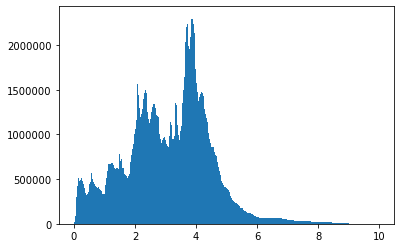

In [37]:
from scipy.spatial.distance import pdist

dists_stable = pdist(df_stable.iloc[:, 0:7])

import matplotlib.pyplot as plt
plt.hist(dists_stable, bins=[i/40. for i in range(400)])

In [38]:
from scipy.spatial.distance import pdist

dists_unstable = pdist(df_unstable.iloc[:, 0:7])

(array([4.110750e+05, 1.294837e+06, 9.214730e+05, 5.962090e+05,
        3.781160e+05, 3.272820e+05, 2.942920e+05, 2.880970e+05,
        2.673600e+05, 2.861450e+05, 2.150500e+05, 2.356140e+05,
        2.285400e+05, 2.290890e+05, 2.812930e+05, 2.216130e+05,
        6.471960e+05, 6.098830e+05, 3.853570e+05, 4.306110e+05,
        3.823410e+05, 4.273200e+05, 4.327070e+05, 3.209640e+05,
        4.156740e+05, 4.961420e+05, 5.064760e+05, 5.099910e+05,
        4.948220e+05, 3.780790e+05, 3.382840e+05, 3.686270e+05,
        5.648890e+05, 5.968750e+05, 5.933660e+05, 7.213200e+05,
        6.240520e+05, 4.613910e+05, 4.371090e+05, 6.722090e+05,
        6.781830e+05, 8.325890e+05, 7.754470e+05, 7.379000e+05,
        7.763410e+05, 7.552790e+05, 8.044170e+05, 8.637530e+05,
        6.868830e+05, 1.051890e+06, 9.631160e+05, 8.482360e+05,
        1.070816e+06, 1.271400e+06, 1.135835e+06, 9.287940e+05,
        7.801600e+05, 8.377480e+05, 9.184540e+05, 1.180497e+06,
        1.431044e+06, 1.392300e+06, 1.44

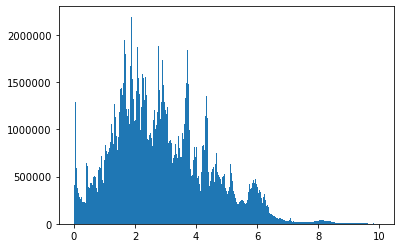

In [39]:
import matplotlib.pyplot as plt
plt.hist(dists_unstable, bins=[i/40. for i in range(400)])

Based on this results we expect that clusters can be found in the case of a stable running source, but the instable source is dominated by noise artifacts.